In [285]:
import matplotlib.pyplot as plt
import numpy as np

import torch
import torchvision

from torch import nn
from torch.utils.data import DataLoader
from tqdm import tqdm

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

### Toy MTL

"Is it a hotdog? Or is it not a hotdog"

Training sets will be identical for each task but labels will be binary classes for whether an example is or is not a particular digit. e.g., task 1 is about identifying digits are a 0 or not. task 2 is about identifying digits are a 1 or not.

In [286]:
mnist_train = torchvision.datasets.MNIST('/tmp/mnist', download=True, train=True)
mnist_test = torchvision.datasets.MNIST('/tmp/mnist', download=True, train=False)

In [290]:
x_train = mnist_train.data
y_train = mnist_train.targets

x_test = mnist_test.data
y_test = mnist_test.targets

In [291]:
t0_digit = 2
t1_digit = 5

# NOTE: x_train, x_test remains the same for both tasks

y_t0_train = torch.where(y_train == t0_digit, 1, 0)
y_t0_test = torch.where(y_test == t0_digit, 1, 0)
y_t1_train = torch.where(y_train == t1_digit, 1, 0)
y_t1_test = torch.where(y_test == t1_digit, 1, 0)

In [292]:
class MultiTaskDataset:
    def __init__(self, x, t0_y, t1_y):
        self.x = x
        self.t0_y = t0_y
        self.t1_y = t1_y
        
    def __getitem__(self, idx):
        return self.x[idx] / 255., self.t0_y[idx], self.t1_y[idx]
            
    def __len__(self):
        return len(self.x)

In [298]:
class MTL(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.backbone = nn.Sequential(
            nn.Linear(28 * 28, 32),
            nn.ReLU(),
        )
        
        self.backbone2 = nn.Sequential(
            nn.Linear(28 * 28, 32),
            nn.ReLU(),
        )
                
        self.t0_head = nn.Linear(32, 1)
        self.t1_head = nn.Linear(32, 1)
    
    def forward(self, x):
        x = x.view(-1, 28 * 28)
        t0_logits = self.t0_head(self.backbone(x))
        t1_logits = self.t1_head(self.backbone(x))
        return t0_logits, t1_logits
    
    def loss(self, x, t0_y, t1_y, t0_lambda=1.0, t1_lambda=1.0):
        t0_logits, t1_logits = self.forward(x)
        t0_logits = t0_logits.view(-1,)
        t1_logits = t1_logits.view(-1,)
        
        t0_loss = nn.functional.binary_cross_entropy_with_logits(t0_logits, t0_y)
        t1_loss = nn.functional.binary_cross_entropy_with_logits(t1_logits, t1_y)
        total_loss = t0_lambda * t0_loss + t1_lambda * t1_loss
        losses = {
            'loss/total': total_loss,
            'loss/t0': t0_loss,
            'loss/t1': t1_loss,
        }
        return losses

In [299]:
def accuracy(y_hat, y):
    assert y_hat.shape == y.shape
    n_classes = y_hat.shape[-1]
    y_hat = y_hat.view(-1, n_classes)
    y = y.view(-1, n_classes)
    n_correct = torch.sum(y_hat == y)
    return n_correct / y_hat.numel()


EPOCHS = 5
LR = 1e-3
BATCH_SIZE = 1024

mtl = MTL()
optimizer = torch.optim.Adam(mtl.parameters(), lr=LR)

train_ds = MultiTaskDataset(x_train, y_t0_train, y_t1_train)
val_ds = MultiTaskDataset(x_test, y_t0_test, y_t1_test)
train_iter = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_iter = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=False)

train_metrics = {'loss/total': [], 
                 'loss/t0': [], 
                 'loss/t1': [],
                 'acc/t0': [],
                 'acc/t1': [],
                }
val_metrics = {'loss/total': [], 
                 'loss/t0': [], 
                 'loss/t1': [],
                 'acc/t0': [],
                 'acc/t1': [],
                }

for epoch in range(EPOCHS):
    mtl.train()
    for batch in tqdm(train_iter, total=len(train_iter)):    
        im, t0_labels, t1_labels = batch
        loss = mtl.loss(im, t0_labels.float(), t1_labels.float())
        total_loss = loss['loss/total']
        
        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()
        
        # loss metrics
        for k in train_metrics.keys():
            if k in loss:
                train_metrics[k].append(loss[k].item())
        
        # accuracy metrics
        t0_logits, t1_logits = mtl.forward(im)
        t0_pred = nn.functional.sigmoid(t0_logits) > 0.5
        t1_pred = nn.functional.sigmoid(t1_logits) > 0.5
        train_metrics['acc/t0'].append(accuracy(t0_pred[:, 0], t0_labels.bool()))
        train_metrics['acc/t1'].append(accuracy(t1_pred[:, 0], t1_labels.bool()))
        

    t0_val_loss = 0
    t1_val_loss = 0
    t0_val_acc = 0
    t1_val_acc = 0
    val_count = 0

    mtl.eval()
    for batch in val_iter:
        im, t0_labels, t1_labels = batch
        val_loss = mtl.loss(im, t0_labels.float(), t1_labels.float())
        
        val_count += len(im)        
        t0_val_loss += val_loss['loss/t0'].item() * len(im)
        t1_val_loss += val_loss['loss/t1'].item() * len(im)
                
        # accuracy metrics
        t0_logits, t1_logits = mtl.forward(im)
        t0_pred = torch.sigmoid(t0_logits) > 0.5
        t1_pred = torch.sigmoid(t1_logits) > 0.5
        t0_val_acc += accuracy(t0_pred[:, 0], t0_labels.bool()).item() * len(im)
        t1_val_acc += accuracy(t1_pred[:, 0], t1_labels.bool()).item() * len(im)
        
    val_metrics['loss/t0'].append(t0_val_loss / val_count)
    val_metrics['loss/t1'].append(t1_val_loss / val_count)
    val_metrics['acc/t0'].append(t0_val_acc / val_count)
    val_metrics['acc/t1'].append(t1_val_acc / val_count)
    

100%|█████████████████████████████| 59/59 [00:00<00:00, 92.88it/s]


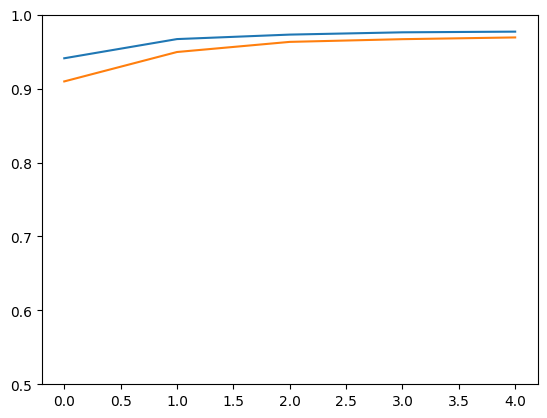

In [296]:
shared_metrics = val_metrics.copy()

plt.ylim([.5, 1])
plt.plot(shared_metrics['acc/t0'])
plt.plot(shared_metrics['acc/t1'])

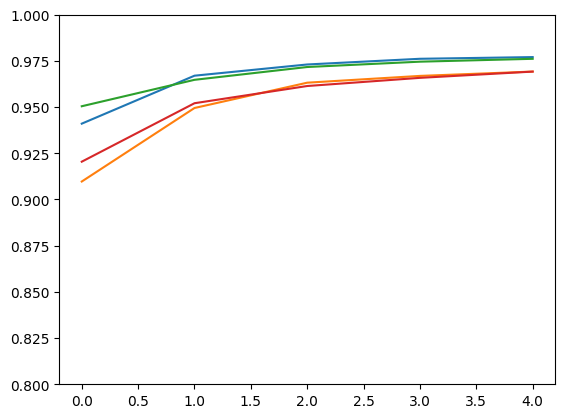

In [300]:
plt.ylim([.8, 1])
plt.plot(shared_metrics['acc/t0'])
plt.plot(shared_metrics['acc/t1'])
plt.plot(val_metrics['acc/t0'])
plt.plot(val_metrics['acc/t1'])